## GMM Preprocessing
sep 04 2020

In [1]:
import os, glob
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

plt.style.use('seaborn')
plt.rcParams["font.family"] = 'NanumGothic'
plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
pathList = glob.glob('../data/provided/*')
for idx, p in enumerate(pathList[:4]):
    name = p.split(' ')[-1].split('.')[0]
    print(f'Load {name}')
    if idx < 3:
        globals()[name] = pd.read_csv(p, engine='python')
    else:
        globals()[name] = pd.read_excel(p)

Load mrc_info
Load samp_train
Load samp_cst_feat
Load variable_dtype


## Gaussian Mixture Model
- Feature Engineering
    - GMM을 이용하여 연속형 변수를 명목형 변수로 변환
    - 가정 :
        - 각 변수는 가맹점 이용 / 미이용 두가지의 분포가 이루어져 있을것
        - Best `BIC Score`을 갖는 변수를 선택하여 모델링에 사용
    - Best K가 2일 경우 파생 변수 후보로 선택

----
## Example : Histogram & Result of Var005

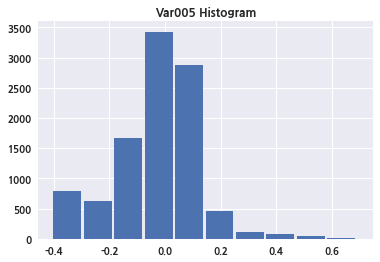

In [3]:
plt.hist(samp_cst_feat.VAR005, width=0.1)
plt.title('Var005 Histogram')
plt.show()

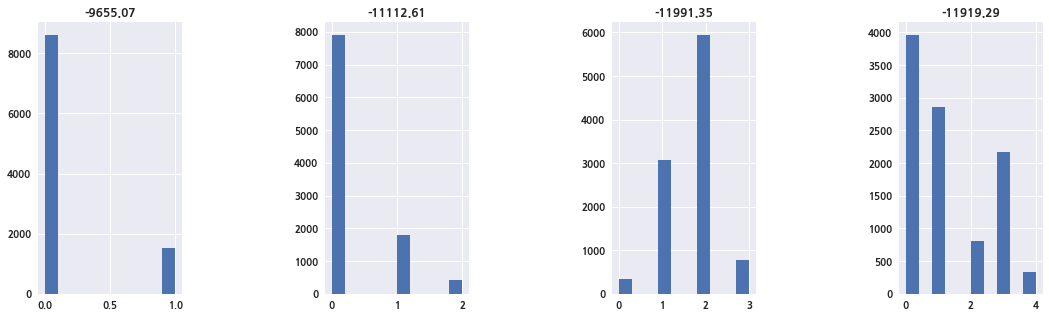

In [4]:
from sklearn.mixture import GaussianMixture
X = samp_cst_feat.VAR005.values.reshape(-1,1)

f, ax = plt.subplots(1, 4, figsize=(18,5))
plt.subplots_adjust(hspace = 1, wspace = 1)

for i,j in enumerate([2,3,4,5]):
    GMM = GaussianMixture(n_components=j)
    prediction = GMM.fit_predict(X)
    
    ax[i].hist(prediction)
    ax[i].set_title(GMM.bic(X).round(2))
    
    
plt.show()

## Var Selection
연속형 변수에 대해서 각 변수에 대한 gmm clustering

In [5]:
# 연속형 변수 리스트
varNums = variable_dtype[variable_dtype['dType']=='numerical']['Variable_Name'].tolist()

# warning 로그 제거
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    
    Gmm_df = pd.DataFrame() # Cluster Prediction Result
    Gmm_Var_list = []
    K_list = [1,2,3,4,5]
    
    for i,var in enumerate(varNums):        
        if i % 20 == 0:
            print(f'gmm clustering :{var}')
            
        X = samp_cst_feat[var].values.reshape(-1,1)        
        BIC_Score = {}

        for i,j in enumerate(K_list):
            GMM = GaussianMixture(n_components=j, random_state=21)
            GMM.fit(X)
            BIC_Score[j] = GMM.bic(X)
        
        
        MaxScore_K = [k for k, v in BIC_Score.items() if v == min(BIC_Score.values())]
        Best_GMM = GaussianMixture(n_components = MaxScore_K[0])
        Gmm_df['gmm'+ var] = Best_GMM.fit_predict(X)

        if MaxScore_K[0] == 2:
            Gmm_Var_list.append(var)


gmm clustering :VAR002
gmm clustering :VAR025
gmm clustering :VAR046
gmm clustering :VAR069
gmm clustering :VAR093
gmm clustering :VAR119
gmm clustering :VAR141
gmm clustering :VAR166
gmm clustering :VAR188
gmm clustering :VAR210


## GMM Cluster K=2

군집을 두가지로 나눌때 BIC 스코어가 가장 낮은 K 가 2인 변수를 선택

In [6]:
print(Gmm_Var_list ,'\n')
print(f'var count : {len(Gmm_Var_list)}')

['VAR024', 'VAR040', 'VAR041', 'VAR048', 'VAR055', 'VAR081', 'VAR087', 'VAR101', 'VAR121', 'VAR125', 'VAR133', 'VAR159', 'VAR161', 'VAR170', 'VAR188', 'VAR190'] 

var count : 16


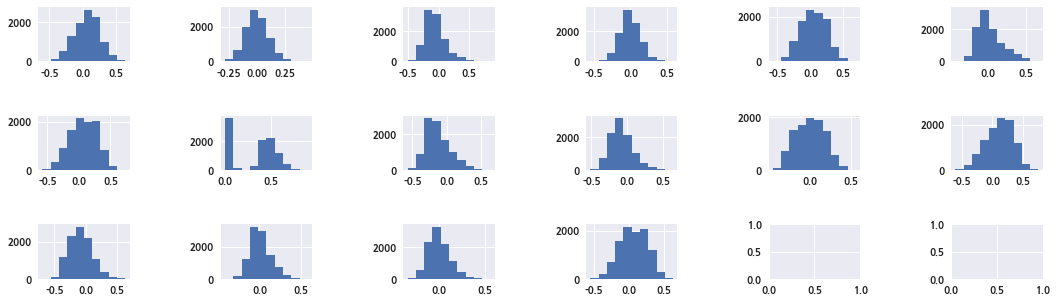

In [7]:
f, ax = plt.subplots(3,6, figsize=(18,5))
plt.subplots_adjust(hspace = 1, wspace = 1)

for i,var in enumerate(Gmm_Var_list):
    ax[i//6,i%6].hist(samp_cst_feat.loc[:,var])

*뭔가 두개의 정규분포가 합쳐진것 같기도 하고.. 모르겠네*

## Cluster Prediction Result
군집화를 통해 범주형 변수로 변환한 연속형 변수를 DataFrame 형식으로 저장

In [8]:
Gmm_df.index = samp_cst_feat.cst_id_di
Gmm_df.to_csv('gmm_cluster_result.csv',index=True)